In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/spooky-author-identification/test.zip
/kaggle/input/spooky-author-identification/train.zip
/kaggle/input/spooky-author-identification/sample_submission.zip


In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer, PorterStemmer
import string
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
import seaborn as sns
import xgboost as xgb
eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [3]:
# load datasets
train = pd.read_csv("/kaggle/input/spooky-author-identification/train.zip")
test = pd.read_csv("/kaggle/input/spooky-author-identification/test.zip")
print(train.shape, test.shape)

(19579, 3) (8392, 2)


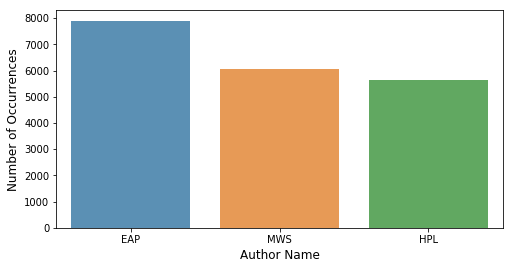

In [4]:
cnt_srs = train['author'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [5]:
# Number of words 
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))

# Number of unique words
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))

# Number of characters
train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))

# Number of stopwords 
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# Number of punctuations
train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# Number of title case words
train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of the words
train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [6]:
# Author mapping
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train['author'].map(author_mapping_dict)
train_id = train['id'].values
test_id = test['id'].values

train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))
train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

In [7]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [8]:
# tfidf vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [9]:
# SVD on word TFIDF
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train = pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [10]:
# Count Vectorizer 
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [11]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train["nb_cvec_eap"] = pred_train[:,0]
train["nb_cvec_hpl"] = pred_train[:,1]
train["nb_cvec_mws"] = pred_train[:,2]
test["nb_cvec_eap"] = pred_full_test[:,0]
test["nb_cvec_hpl"] = pred_full_test[:,1]
test["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.4530287297009889


In [12]:
### Fit transform the tfidf vectorizer 
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train["nb_tfidf_char_eap"] = pred_train[:,0]
train["nb_tfidf_char_hpl"] = pred_train[:,1]
train["nb_tfidf_char_mws"] = pred_train[:,2]
test["nb_tfidf_char_eap"] = pred_full_test[:,0]
test["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947421


In [13]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train = pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [14]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=42, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 2
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2200

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=200, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model


In [15]:
cols_to_drop = ['id', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=42, colsample=0.6)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("cv scores : ", cv_scores)


[0]	train-mlogloss:1.01542	test-mlogloss:1.0172
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 200 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20]	train-mlogloss:0.468104	test-mlogloss:0.48921
[40]	train-mlogloss:0.38763	test-mlogloss:0.415603
[60]	train-mlogloss:0.363027	test-mlogloss:0.395252
[80]	train-mlogloss:0.34834	test-mlogloss:0.385614
[100]	train-mlogloss:0.337203	test-mlogloss:0.379241
[120]	train-mlogloss:0.328077	test-mlogloss:0.37435
[140]	train-mlogloss:0.320531	test-mlogloss:0.370939
[160]	train-mlogloss:0.313978	test-mlogloss:0.368358
[180]	train-mlogloss:0.308344	test-mlogloss:0.366516
[200]	train-mlogloss:0.303144	test-mlogloss:0.364425
[220]	train-mlogloss:0.298287	test-mlogloss:0.363482
[240]	train-mlogloss:0.293577	test-mlogloss:0.361852
[260]	train-mlogloss:0.289599	test-mlogloss:0.361295
[280]	train-mlogloss:0.286035	test-mlogloss:0.360481
[300]	train-mlogloss:0.282437	test-mlogloss:0.359414
[320]	train-mlogloss:0.279001	test-mlogloss:0.358873
[340]	train-mlogloss:0.275537	test-mlogloss:0.358423
[360]	train-mlogloss:0.272362	test-mlogloss:0.358266
[380]	train-mlogloss:0.269332	test-mlogloss:0.357885
[

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20]	train-mlogloss:0.473574	test-mlogloss:0.47421
[40]	train-mlogloss:0.394018	test-mlogloss:0.395068
[60]	train-mlogloss:0.369408	test-mlogloss:0.373029
[80]	train-mlogloss:0.354831	test-mlogloss:0.361836
[100]	train-mlogloss:0.343542	test-mlogloss:0.354283
[120]	train-mlogloss:0.334786	test-mlogloss:0.348828
[140]	train-mlogloss:0.327472	test-mlogloss:0.34434
[160]	train-mlogloss:0.320968	test-mlogloss:0.341241
[180]	train-mlogloss:0.315216	test-mlogloss:0.3382
[200]	train-mlogloss:0.309815	test-mlogloss:0.336483
[220]	train-mlogloss:0.305162	test-mlogloss:0.334204
[240]	train-mlogloss:0.300757	test-mlogloss:0.332598
[260]	train-mlogloss:0.296676	test-mlogloss:0.331667
[280]	train-mlogloss:0.292687	test-mlogloss:0.330757
[300]	train-mlogloss:0.289296	test-mlogloss:0.329802
[320]	train-mlogloss:0.28578	test-mlogloss:0.329101
[340]	train-mlogloss:0.282374	test-mlogloss:0.328523
[360]	train-mlogloss:0.279128	test-mlogloss:0.327546
[380]	train-mlogloss:0.275967	test-mlogloss:0.326896
[4

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20]	train-mlogloss:0.475053	test-mlogloss:0.469067
[40]	train-mlogloss:0.394581	test-mlogloss:0.389679
[60]	train-mlogloss:0.369721	test-mlogloss:0.369388
[80]	train-mlogloss:0.355609	test-mlogloss:0.358833
[100]	train-mlogloss:0.344605	test-mlogloss:0.350566
[120]	train-mlogloss:0.335896	test-mlogloss:0.345191
[140]	train-mlogloss:0.328192	test-mlogloss:0.34068
[160]	train-mlogloss:0.321803	test-mlogloss:0.337498
[180]	train-mlogloss:0.315934	test-mlogloss:0.334545
[200]	train-mlogloss:0.310825	test-mlogloss:0.332557
[220]	train-mlogloss:0.30613	test-mlogloss:0.331239
[240]	train-mlogloss:0.301764	test-mlogloss:0.329641
[260]	train-mlogloss:0.297551	test-mlogloss:0.328884
[280]	train-mlogloss:0.293657	test-mlogloss:0.327736
[300]	train-mlogloss:0.289975	test-mlogloss:0.326925
[320]	train-mlogloss:0.286593	test-mlogloss:0.326492
[340]	train-mlogloss:0.283179	test-mlogloss:0.325567
[360]	train-mlogloss:0.280148	test-mlogloss:0.325212
[380]	train-mlogloss:0.277139	test-mlogloss:0.324746

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20]	train-mlogloss:0.471914	test-mlogloss:0.476546
[40]	train-mlogloss:0.392551	test-mlogloss:0.400066
[60]	train-mlogloss:0.367397	test-mlogloss:0.378551
[80]	train-mlogloss:0.352455	test-mlogloss:0.367781
[100]	train-mlogloss:0.341188	test-mlogloss:0.360506
[120]	train-mlogloss:0.332462	test-mlogloss:0.355349
[140]	train-mlogloss:0.325154	test-mlogloss:0.351854
[160]	train-mlogloss:0.318886	test-mlogloss:0.348673
[180]	train-mlogloss:0.313191	test-mlogloss:0.346282
[200]	train-mlogloss:0.307798	test-mlogloss:0.344038
[220]	train-mlogloss:0.303169	test-mlogloss:0.342574
[240]	train-mlogloss:0.29911	test-mlogloss:0.341237
[260]	train-mlogloss:0.29512	test-mlogloss:0.339981
[280]	train-mlogloss:0.291401	test-mlogloss:0.33916
[300]	train-mlogloss:0.287902	test-mlogloss:0.338366
[320]	train-mlogloss:0.284332	test-mlogloss:0.337971
[340]	train-mlogloss:0.281124	test-mlogloss:0.337084
[360]	train-mlogloss:0.278093	test-mlogloss:0.335925
[380]	train-mlogloss:0.27474	test-mlogloss:0.335307
[

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20]	train-mlogloss:0.465877	test-mlogloss:0.4697
[40]	train-mlogloss:0.389875	test-mlogloss:0.396872
[60]	train-mlogloss:0.366635	test-mlogloss:0.377581
[80]	train-mlogloss:0.35207	test-mlogloss:0.367902
[100]	train-mlogloss:0.341029	test-mlogloss:0.361298
[120]	train-mlogloss:0.332186	test-mlogloss:0.35579
[140]	train-mlogloss:0.324513	test-mlogloss:0.352316
[160]	train-mlogloss:0.318236	test-mlogloss:0.349291
[180]	train-mlogloss:0.312591	test-mlogloss:0.347301
[200]	train-mlogloss:0.307404	test-mlogloss:0.34561
[220]	train-mlogloss:0.302741	test-mlogloss:0.344251
[240]	train-mlogloss:0.298306	test-mlogloss:0.343149
[260]	train-mlogloss:0.294296	test-mlogloss:0.341976
[280]	train-mlogloss:0.290316	test-mlogloss:0.341775
[300]	train-mlogloss:0.286636	test-mlogloss:0.340936
[320]	train-mlogloss:0.28316	test-mlogloss:0.340356
[340]	train-mlogloss:0.279761	test-mlogloss:0.339383
[360]	train-mlogloss:0.27671	test-mlogloss:0.338868
[380]	train-mlogloss:0.273679	test-mlogloss:0.33812
[400]

In [16]:
sub = pd.DataFrame(pred_full_test)
sub.columns = ['EAP', 'HPL', 'MWS']
sub.insert(0, 'id', test_id)
sub.to_csv("submission.csv", index=False)